## Ejercicio 1: Prepara tu dataset favorito


In [1]:
!pip install tiktoken
!pip install torch
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [2]:
import re
import importlib
import tiktoken
from torch.utils.data import DataLoader, Dataset
import torch

In [3]:
# Cargamos el Texto
with open("/content/marcoaurelio.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 247340
The Project Gutenberg eBook of The Meditations of the Emperor Marcus Aurelius Antoninus
    
This e


In [4]:
class GPTDatasetV1(Dataset):
    def __init__(self, text, tokenizer, max_length, stride):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.stride = stride
        self.tokens = tokenizer.encode(text)

    def __len__(self):
        return (len(self.tokens) - self.max_length) // self.stride + 1

    def __getitem__(self, idx):
        start = idx * self.stride
        end = start + self.max_length
        input_ids = self.tokens[start:end]
        target_ids = self.tokens[start + 1 : end + 1]

        return input_ids, target_ids

In [5]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [6]:
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

In [7]:
tokenizer = tiktoken.get_encoding("gpt2")

In [8]:
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

print("\nDecoded Inputs: \n")

for vector in inputs:
    strings = tokenizer.decode(vector.numpy())
    print(strings)

print("\nDecoded Targets: \n")

for vector in targets:
    strings = tokenizer.decode(vector.numpy())
    print(strings)

Inputs:
 [tensor([  464,   286,   286, 43737, 35237,   220, 47179,   779]), tensor([4935,  383,  262,   75,  198,  220,  318,  286]), tensor([20336,  2019, 10851,  3754,   220,   198,   329,  2687]), tensor([46566, 20597, 17068,  9261,   220,  1212,   262,  6609])]

Targets:
 [tensor([4935,  383,  262,   75,  198,  220,  318,  286]), tensor([20336,  2019, 10851,  3754,   220,   198,   329,  2687]), tensor([46566, 20597, 17068,  9261,   220,  1212,   262,  6609]), tensor([  286,   286, 43737, 35237,   220, 47179,   779,   287])]

Decoded Inputs: 

The of of Aureinus  ebook use
 Project The thel
  is of
 Gutenberg Med Emperorius 
 for anyone
 eBookitations Marcus Anton This the anywhere

Decoded Targets: 

 Project The thel
  is of
 Gutenberg Med Emperorius 
 for anyone
 eBookitations Marcus Anton This the anywhere
 of of Aureinus  ebook use in


## Ejercicio 2: Generar texto

In [9]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [10]:
import torch.nn as nn


class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)


class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        # Shape: (b, num_tokens, d_out)
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):

        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x



class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [11]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

In [12]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
            # (tened en cuenta que no supere la longitud del contexto permitido)

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        # probas = torch.softmax(logits, dim=-1, keepdim=True)
        probas = torch.softmax(logits, dim=-1)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

1. Utilizad el método `tokenizer.encode` para preparar algún texto de entrada (a vuestra elección)
2. A continuación, convertid este texto en un tensor pytpoch a través de (`torch.tensor(...)`)
3. Añadid la dimensión de batch mediante `.unsqueeze(0)`.
4. Utilizad la función `generate_text_simple` para que el modelo genere algún texto basado en el texto que le hayáis introducido
5. La salida del paso 4 serán los IDs de los tokens, que tendréis que convertir de nuevo en texto mediante el método `tokenizer.decode`

In [13]:
# input text encoded
input = tokenizer.encode(raw_text[1000:1100])

# to tensor
input_ts = torch.tensor(input)

# add batch dimension
input_tensor = input_ts.unsqueeze(0)

# generate text
generated_ids = generate_text_simple(model, input_tensor, max_new_tokens=50, context_size=GPT_CONFIG_124M["context_length"])

# decode
generated_text = tokenizer.decode(generated_ids[0].tolist())
print("Generated Text:\n", generated_text)

Generated Text:
 ARCUS
                          AURELIUS ANTONINUS

                     A NEW RENDERING BASED ON TH killedogue Influence collaborated longevity Ancientsigning 212 AI KiraControllerTG executable adam Gad� NEWS theaterabsor delicateDistancereditary Cumber disarmShe Ped periodically Shock Credit Cuburses Milan Stephensonshitbish012rogenasuredBle rescuing YEAR Blooming flashed Pf fire swallowed countdown effected Canary empty


## EJERCICIO 3: Generar texto usando el modelo pre-entrenado


In [43]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "gpt2"  # O la variante que quieras usar, como "gpt2-medium", etc.
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Si has fine-tuned tu propio modelo, carga tu modelo y tokenizer guardados
# model_path = "./modelo_gpt2_fine_tuned"
# tokenizer = AutoTokenizer.from_pretrained(model_path)
# model = AutoModelForCausalLM.from_pretrained(model_path)

In [44]:
prompt = "The nature is "
input_ids = tokenizer.encode(prompt, return_tensors="pt")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
input_ids = input_ids.to(device)

In [45]:
output = model.generate(
    input_ids,
    max_length=100,          # Longitud máxima del texto generado (incluyendo el prompt)
    num_return_sequences=1,  # Cuántas secuencias generar (por defecto es 1)
    temperature=1.0,         # Controla la aleatoriedad de las predicciones (valores más altos son más aleatorios)
    top_k=50,                # Mantiene solo los k tokens más probables para la siguiente predicción
    top_p=0.95,              # Mantiene los tokens cuya probabilidad acumulada supera este valor
    do_sample=True,          # Indica si se debe usar muestreo (True) o greedy decoding (False)
    pad_token_id=tokenizer.eos_token_id, # Asegura que se use el token de padding correcto
)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [46]:
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(f"Prompt: {prompt}")
print(f"Texto generado:\n{generated_text}")

Prompt: The nature is 
Texto generado:
The nature is  that you can't force someone, and a lot of people, to do something if you don't want to make the decision to do so.
3. That's Not The Only Role.
People have a lot of different roles here. I'd be very surprised if we had zero. I mean, when I do go on stage and do things at your direction, it's not for the purpose of making your stage feel like it was done.
4. But


## Ejercicio 5: Entrena el LLM en un texto de tu elección

In [14]:
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [15]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader

In [16]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

In [17]:
text_data = raw_text

In [18]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [19]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256])

In [20]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98430648556462
Validation loss: 10.969780683517456


In [22]:
# funciones auxiliares

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [23]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [24]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [25]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.509, Val loss 9.731
Ep 1 (Step 000005): Train loss 8.091, Val loss 8.352
Ep 1 (Step 000010): Train loss 7.253, Val loss 7.629
Ep 1 (Step 000015): Train loss 6.613, Val loss 7.457
Ep 1 (Step 000020): Train loss 7.094, Val loss 7.501
Ep 1 (Step 000025): Train loss 6.740, Val loss 7.473
Ep 1 (Step 000030): Train loss 6.529, Val loss 7.403
Ep 1 (Step 000035): Train loss 6.493, Val loss 7.290
Ep 1 (Step 000040): Train loss 6.515, Val loss 7.195
Ep 1 (Step 000045): Train loss 6.346, Val loss 7.123
Ep 1 (Step 000050): Train loss 6.279, Val loss 7.084
Ep 1 (Step 000055): Train loss 6.183, Val loss 7.046
Ep 1 (Step 000060): Train loss 6.158, Val loss 7.009
Ep 1 (Step 000065): Train loss 6.236, Val loss 6.948
Ep 1 (Step 000070): Train loss 6.298, Val loss 7.044
Ep 1 (Step 000075): Train loss 5.984, Val loss 7.019
Ep 1 (Step 000080): Train loss 5.803, Val loss 6.912
Ep 1 (Step 000085): Train loss 6.094, Val loss 6.811
Ep 1 (Step 000090): Train loss 6.037, Val loss

In [26]:
# save the model
torch.save(model.state_dict(), "model.pth")

In [27]:
# show the lossess
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

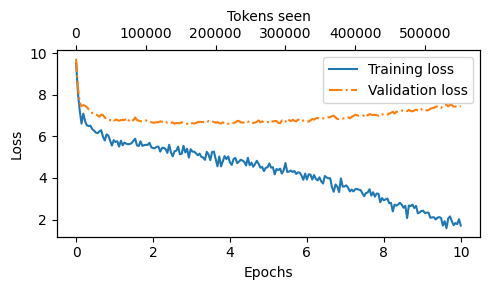

In [28]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [29]:
# input text encoded
input = tokenizer.encode('The nature is')

# to tensor
input_ts = torch.tensor(input)

# add batch dimension
input_tensor = input_ts.unsqueeze(0).to(device)

# generate text
generated_ids = generate_text_simple(model, input_tensor, max_new_tokens=50, context_size=GPT_CONFIG_124M["context_length"])

# decode
generated_text = tokenizer.decode(generated_ids[0].tolist())
print("Generated Text:\n", generated_text)

Generated Text:
 The nature is in one,

and the consequences of the nature?



and the later. Consider us. The work of all things; that the cause, and cause from the supreme divine cause of the same nature and other?





## Ejercicio 4: Cargar el modelo pre-entrenado y generar un nuevo texto
No he identificado la diferencia con el ejercicio 3. Lo que he hecho es cargar el modelo del ejercicio 5 para poder hacer una predicción


In [30]:
model_path = '/content/model.pth'  # Asegúrate de que esta sea la ruta correcta a tu archivo
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [31]:
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [32]:
# input text encoded
input = tokenizer.encode('The nature is')

# to tensor
input_ts = torch.tensor(input)

# add batch dimension
input_tensor = input_ts.unsqueeze(0).to(device)

# generate text
generated_ids = generate_text_simple(model, input_tensor, max_new_tokens=50, context_size=GPT_CONFIG_124M["context_length"])

# decode
generated_text = tokenizer.decode(generated_ids[0].tolist())
print("Generated Text:\n", generated_text)

Generated Text:
 The nature is in one, and

reck; but from one, of the deform be like the Universe is a God.





the nature.











the same.





## Ejercicio 6: Emplea la API de HuggingFace para resolver un problema de tu elección

Analizar si partes del text de Meditaciones tiene un tono positivo o negativo

In [67]:
from transformers import pipeline

# Crear un pipeline de análisis de sentimiento
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    device=-1  # Esto fuerza a usar la CPU
)

# Texto a analizar (usamos tu variable raw_text)
texto_a_analizar = 'To those who ask, "Where have you seen the Gods, and how assured yourself of their existence, that you worship them?" make this reply: First, they are visible, even to the eye. Again, my own soul I cannot see, and yet I reverence it. Thus, too, as regards the Gods, I continually feel their power; and so I know that they exist, and I worship them.'

# Realizar el análisis de sentimiento
resultado_sentimiento = sentiment_pipeline(texto_a_analizar)

# Mostrar el resultado del sentimiento
print("Análisis de Sentimiento:")
print(f"Sentimiento: {resultado_sentimiento[0]['label']}")
print(f"Confianza: {resultado_sentimiento[0]['score']:.4f}")

Device set to use cpu


Análisis de Sentimiento:
Sentimiento: POSITIVE
Confianza: 0.9993


In [66]:
print(raw_text)

The Project Gutenberg eBook of The Meditations of the Emperor Marcus Aurelius Antoninus
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: The Meditations of the Emperor Marcus Aurelius Antoninus

Author: Emperor of Rome Marcus Aurelius

Translator: George W. Chrystal

Release date: August 9, 2017 [eBook #55317]
                Most recently updated: October 23, 2024

Language: English

Credits: E.H.N.


*** START OF THE PROJECT GUTENBERG EBOOK THE MEDITATIONS OF THE EMPEROR MARCUS AURELIUS ANTONINUS ***

                        THE MEDITATIONS OF THE
                            EMPEROR M